Universidad Galileo

Statistical Learning I

PAPD - Sección V

Sergio José Barrios Martínez

Carnet No. 19012765

# Práctica No. 3

In [1]:
import numpy as np
import imageio as imio
import matplotlib.pyplot as plt
import datetime

Si tienes algún error al ejecutar la celda anterior verifica que tu ambiente de anaconda tenga las librerías necesarias.

# Clasificación con K-nearest neighbors
En este notebook vamos a implementar K-nearest neighbor, nuestro algoritmo va a **clasificar** a que raza pertenece la imagen de un perro, para entrenar nuestro algoritmo vamos a utilizar un set de datos contiene imagenes de 120 razas de perros, en total son 10,222 imagenes.

Data: [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/data)

#### Pre-procesamiento

El pre-procesamiento ya fue realizado y el dataset preparado y esta listo para usarse, para esto se aplico un proceso conocido como "transfer learning" usando la red neuronal "Inception" de Google(tema a cubrirse en proximas clases)  , para esta tarea ignoremos este detalle  y pensemos que se nos da un dataset con features donde cada columna representa una característica de entrada importante,pero no nos interesa conocer los detalles. 

Estas features/características fueron almacenadas en un matriz de numpy.

En esta parte del notebook solo hay que ejecutar las celdas para cargar los datos, estos datos van a servir de entrada para nuestra implementación de K-nearest neighbors con tensorflow.

### Referencias opcionales para transfer learning y "Google inception"
##### Inception
https://www.tensorflow.org/tutorials/image_recognition

https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html

##### Transfer Learning
https://www.datacamp.com/community/tutorials/transfer-learning

In [2]:
images_inception_features = './pre-processing/training_inception_features_array.npy'
training_image_labels_array = './pre-processing/training_image_labels_array.npy'
training_image_names_array = './pre-processing/training_image_names_array.npy'

In [3]:
TRAIN_DICTIONARY_KEYS = ["images", "label","features"]

training_set_dict = dict()
    
training_set_dict['images_name'] = np.load(training_image_names_array, allow_pickle=True)
training_set_dict['label'] = np.load(training_image_labels_array, allow_pickle=True)
training_set_dict['features'] = np.load(images_inception_features, allow_pickle=True)


#  K-Nearest Neighbors

La data la vamos a manejar en los siguientes 3 arreglos: 

- features    : features de la imagen dadas por google Inception
- labels      : label de la imagen, identifica que raza es
- images_name : nombre de la imgen original, si descargan el dataset con link en la descripcion pueden buscar la imagen original por este nombre.

In [4]:
## Cargamos las features y las labes de cada feature
features = training_set_dict['features']
labels = training_set_dict['label']
images_name = training_set_dict['images_name']

Las labels pertenecientes a las features tienen el mismo indice, Ejemplo:

Label:  golden_retriever
Nombre:  0021f9ceb3235effd7fcde7f7538ed62


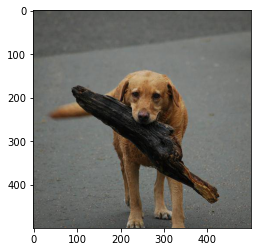

In [5]:
# Indice 4

print('Label: ',labels[4])

print('Nombre: ',images_name[4])

img = imio.imread('./data/train/'+images_name[4]+'.jpg')
plt.imshow(img)


### Implementa tu codigo de  K-Neighbors aqui:

El siguiente es un ejemplo de como puedes  definir tu función para predecir la raza sobre un punto x_predict ,a través de uscar los "k" vecinos mas cercanos en X_train y devolver como predicción el "y" que mas se repite(la moda) correspondiente a esos "k" valores de X_train , este "y" estará dado por Y_train.

Un ejemplo  de KNN en tensorflow: http://marubon-ds.blogspot.com/2017/09/knn-k-nearest-neighbors-by-tensorflow.html (este tiene diferencias, usar como guía no copiar literal, por ejemplo este usa una métrica de distancia diferente a la que debemos usar: distancia euclidiana )


#### Instrucciones:
1. Implementar KNN
2. Agregar el grafo de tensorboard
3. Ejecutar el modelo con las 2 imagenes de prueba.

### TensorFlow

Grafo para Algoritmo K-NN

### Definición del Grafo

In [6]:
import tensorflow as tf
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [7]:
grafo = tf.Graph()

with grafo.as_default():
    
    # Placeholders
    # Características de Imagen a Predecir.
    x_new = tf.placeholder(tf.float32,[1,2048],"x_nuevo") 
    # Características de Imagenes Entrenamiento.
    x_train = tf.placeholder(tf.float32,[10222,2048],"caracteristicas_entrenamiento") 
    # Etiquetas de Entrenamiento
    y_train = tf.placeholder(tf.string,[10222,1],"etiquetas_entrenamiento")
    # Hiper-parámetro de Número de Vecinos
    k_vecinos = tf.placeholder(tf.int32,name="k-neighbors") 

    # Distancia Euclidiana X_nuevo y X_entrenamiento
    with tf.name_scope("distancia_euclidiana"):
        suma_dif_cuadrados = tf.math.reduce_sum(tf.math.squared_difference(x_train,x_new),axis=1)
        distancia_euclidiana = tf.math.sqrt(suma_dif_cuadrados)
    
    # Inversión de Distancias (Negativo de Distancias)
    with tf.name_scope("negativo"):
        distancia_negativa = tf.negative(distancia_euclidiana)
        
    # Selección de Top K distancias (distancias menos negativas o más pequeñas)
    # y luego Indexing para Obtener Valores de Y en el Set de Entrenamiento
    with tf.name_scope("k_neighbors"):
        top_k_distancias,top_k_pos_distancias = tf.math.top_k(distancia_negativa,k_vecinos)
        k_y_entrenamiento = tf.gather(y_train,top_k_pos_distancias)
          
    # Cálculo de la Moda para el arreglo de strings. Inicialmente, se cuentan las ocurrencias únicas
    # y luego se utiliza ARGMAX para encontrar la posición de la ocurrencia más alta.
    with tf.name_scope("moda"):
        _,_,suma_ocurrencias_y = tf.unique_with_counts(k_y_entrenamiento[0])
        y_hat = k_y_entrenamiento[tf.argmax(suma_ocurrencias_y)]
    
    
    init = tf.global_variables_initializer()

## Grafo en TensorBoard

<img src=".\Imagenes_t3\Grafo.png">


## Grafo Desplegado en TensorBoard

<img src=".\Imagenes_t3\Grafo_desplegado.png">

In [8]:
# Función de Clasificacion con KNN
def predecir_raza_KNN(x_nuevo,x_entrenamiento,y_entrenamiento,k):
    
    now = datetime.datetime.now()
    
    
    # Acondicionamiento de vectores de entrada
    x_nuevo = np.expand_dims(x_nuevo,axis=0)
    y_entrenamiento = np.transpose(np.expand_dims(y_entrenamiento,axis=0))
    
    tf.reset_default_graph()
    
    # Ejecución de Grafo
    with tf.Session(graph=grafo) as session:
        # String de Configuración 
        #("Año""Mes""Dia"-"Hora""Minuto""Segundo")
        writer = tf.summary.FileWriter('./graphs_t3/'+now.strftime("%Y%m%d-%H%M%S"), session.graph)
        session.run(init) # Inicialización de Variables

        # Se envían los parámetros a ejecutar
        feed_dict = {x_new:x_nuevo,x_train:x_entrenamiento,y_train:y_entrenamiento,k_vecinos:k}
        
        # Ejecución de KNN
        y = session.run(y_hat,feed_dict=feed_dict)
        
        writer.close()
              
    return y[0]


## Probamos el algoritmo con nuevas imagenes 

Como buena practica luego de entrenar nuestro algoritmo, lo probamos con imagenes que no ha visto antes 

In [9]:
test_features = np.load('./data/test/test_inception_features_array.npy')

### Prueba 1

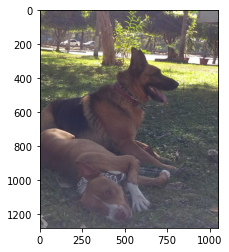

In [10]:
img_test = imio.imread('./data/test/test1.jpg')
plt.imshow(img_test)

In [11]:
predict_image = test_features[0]
predecir_raza_KNN(predict_image,features,labels,20)

## Ejecuta tu modelo con la entrada de `predict_image`
# Deberiamos obtener: german_shepherd

b'german_shepherd'

### Prueba 2

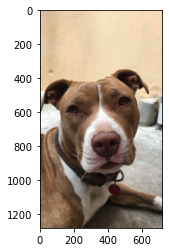

In [12]:
img_test = imio.imread('./data/test/test2.jpg')
plt.imshow(img_test)

In [13]:
## Ejecuta tu modelo con la entrada de `predict_image`
# Deberiamos obtener: american_staffordshire_terrier #
predict_image = test_features[1]
predecir_raza_KNN(predict_image,features,labels,20)


b'american_staffordshire_terrier'